In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from astropy.visualization import HistEqStretch, ImageNormalize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegressionCV
from astropy.table import Table

from scipy.stats import norm
from scipy.stats import skew
from scipy.stats import kurtosis
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.cluster import HDBSCAN
from sklearn.neighbors import NearestNeighbors
from scipy.stats import lognorm
from sklearn.preprocessing import scale as sk_scale

from tqdm import tqdm
import itertools

import umap

from agabpylib.plotting.plotstyles import useagab, apply_tufte
from agabpylib.stats.robuststats import rse
from reflspectratools import (
    plot_spectra_collection,
    load_dr3_data,
    create_ml_training_classes,
    extract_spectra,
    prep_classifier_inputs,
)

useagab(fontsize=22, linewidths=3, axislinewidths=2)
from scipy.stats import linregress

In [2]:
ssospectra = load_dr3_data(clipspectra=False)    #Corrected with correction factors
n_asteroids = ssospectra.number_mp.unique().size
wavelengths = ssospectra["wavelength"].unique()
wavelengths.sort()
ssotypes = create_ml_training_classes(ssospectra, filter=True)

ssoparams = Table.read(".\data\DR3ReflectanceSpectra.fits.gz").to_pandas()
#ssoparams["denomination"] = ssoparams.denomination.str.decode("utf-8")
#ssoparams["parent_name"] = ssoparams.parent_name.str.decode("utf-8")

In [3]:
for i in wavelengths:
    print(f'{i} : {np.mean(ssospectra.reflectance_spectrum[ssospectra.wavelength == i])}')

374.0 : 1.2521841526031494
418.0 : 0.9866716861724854
462.0 : 0.9309912919998169
506.0 : 0.9507800936698914
550.0 : 1.0
594.0 : 1.022857427597046
638.0 : 1.0573539733886719
682.0 : 1.1216259002685547
726.0 : 1.1426825523376465
770.0 : 1.1548733711242676
814.0 : 1.1548398733139038
858.0 : 1.144045114517212
902.0 : 1.1444615125656128
946.0 : 1.1869895458221436
990.0 : 1.3036561012268066
1034.0 : 1.5791423320770264


In [4]:
stat_pd = pd.DataFrame(columns=['wavelength','skewness', 'kurtosis1'])

for i in wavelengths:
    copied = ssospectra.reflectance_spectrum[ssospectra.wavelength==i].dropna().values
    skewed = round(skew(copied),2)
    kurtosised = round(kurtosis(copied),2)

    if i == 374:
        copied_2 = [i for i in copied if i <= 2.5]
        
    elif i == 946:
        copied_2 = [i for i in copied if i <= 3 and i >= 0.5]
    elif i == 990:
        copied_2 = [i for i in copied if i <= 3 and i >= 0.5]
    elif i == 1034:
        copied_2 = [i for i in copied if i <= 3 and i >= 0.6]
    else:
        copied_2 = copied
    skewed_2 = round(skew(copied_2),2)
    kurtosised_2 = round(kurtosis(copied_2),2) 
    print(skewed, skewed_2, kurtosised, kurtosised_2)
    
    if skewed == skewed_2: 
        stat_pd.loc[len(stat_pd)] = [i, skewed, kurtosised]
    else:
        stat_pd.loc[len(stat_pd)] = [i, [skewed, skewed_2], [kurtosised, kurtosised_2]]
    #stat_pd = pd.DataFrame({'a' : skewed, 'b':skewed_2, 'c':kurtosised, 'd':kurtosised_2})
    #dropped_na = data.reflectance_spectrum[data.wavelength == wavelength].dropna()
    #spectra_reflectance = dropped_na.values    #Dropping all the NaN values in the data
    

9.19 0.95 163.63 0.93
0.62 0.62 0.81 0.81
0.34 0.34 -0.06 -0.06
0.27 0.27 0.89 0.89
0.0 0.0 -3.0 -3.0
-0.06 -0.06 0.7 0.7
0.26 0.26 0.81 0.81
0.19 0.19 0.31 0.31
-0.02 -0.02 -0.13 -0.13
-0.1 -0.1 -0.26 -0.26
0.07 0.07 0.57 0.57
0.11 0.11 0.22 0.22
0.11 0.11 0.64 0.64
0.3 0.3 0.88 0.88
0.76 0.76 1.57 1.57
1.5 0.85 90.3 0.76


In [5]:
stat_pd.set_index('wavelength')

,skewness,kurtosis1
wavelength,,
374.0,"[9.19, 0.95]","[163.63, 0.93]"
418.0,0.62,0.81
462.0,0.34,-0.06
506.0,0.27,0.89
550.0,0.0,-3.0
594.0,-0.06,0.7
638.0,0.26,0.81
682.0,0.19,0.31
726.0,-0.02,-0.13


In [6]:
values = list(stat_pd.skewness.values[1:-1])
mu, std = norm.fit(values)
chance_skewness_cdf =  (1- norm(mu, std).cdf(0.76))*100

values_kurtosis = list(stat_pd.kurtosis1.values[1:-1])
mu_kurt, std_kurt = norm.fit(values_kurtosis)
chance_kurts_cdf =  (1- norm(mu_kurt, std_kurt).cdf(0.81))*100
print(chance_skewness_cdf)
print(chance_kurts_cdf)

1.0240540816594645
30.314474259792014


In [7]:
1-norm(mu, std).cdf(0.34)

0.2849501714819086

In [8]:
b = ssospectra.reflectance_spectrum_normalized.isnull()
wavelengths = ssospectra[b].wavelength.unique()

In [9]:
def distribution_function(data, wavelength):
    copied = data.copy()
    
    dropped_na = data.reflectance_spectrum[data.wavelength == wavelength].dropna()
    spectra_reflectance = dropped_na.values    #Dropping all the NaN values in the data
    
    if wavelength == 374: 
        spectra_reflectance = [i for i in spectra_reflectance if i <= 2.5]     #Only selecting data that is pretty
    elif wavelength == 946:
        spectra_reflectance = [i for i in spectra_reflectance if i <= 1.65 and i >= 0.75]
    elif wavelength == 990:
        spectra_reflectance = [i for i in spectra_reflectance if i <= 2 and i >= 0.6]
    elif wavelength == 1034:
        spectra_reflectance = [i for i in spectra_reflectance if i <= 3 and i >= 0.6]
    
    shape, loc, scale = lognorm.fit(spectra_reflectance, floc = 0)         #Fitting the data to a log normal distribution
    
    NaN_data = data.reflectance_spectrum[data.wavelength == wavelength].isnull()
    NaN_values = len(data.reflectance_spectrum[data.wavelength == wavelength][NaN_data])    #Finding how many NaN values there are
    print(f'Wavelength {wavelength} has {NaN_values} NaN values')         #Number of NaN values per wavelength
    
    new_values = iter(np.float32(lognorm.rvs(shape, loc, scale, size=NaN_values)))
    copied.reflectance_spectrum[data.wavelength == wavelength] = data.reflectance_spectrum[data.wavelength == wavelength].apply(lambda x: next(new_values) if pd.isna(x) else x)  
   
    #x = np.linspace(min(spectra_reflectance), max(spectra_reflectance), 1000)
    #pdf = lognorm.pdf(x, shape, loc, scale)
    #plt.hist(spectra_reflectance, density=True, alpha=0.5)
    #plt.plot(x, pdf, 'r-', lw=2, label="Lognormal Fit")
    #plt.show()
    
    return copied

In [10]:
wl_946 = distribution_function(ssospectra, 946)
wl_990 = distribution_function(wl_946, 990)

Wavelength 946 has 1 NaN values


<ipython-input-9-a30fcd4497d0>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copied.reflectance_spectrum[data.wavelength == wavelength] = data.reflectance_spectrum[data.wavelength == wavelength].apply(lambda x: next(new_values) if pd.isna(x) else x)


Wavelength 990 has 1 NaN values


<ipython-input-9-a30fcd4497d0>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copied.reflectance_spectrum[data.wavelength == wavelength] = data.reflectance_spectrum[data.wavelength == wavelength].apply(lambda x: next(new_values) if pd.isna(x) else x)


In [11]:
new_spectra = wl_990.copy()
new_spectra = new_spectra.drop(new_spectra[new_spectra.wavelength == 374].index)
new_spectra = new_spectra.drop(new_spectra[new_spectra.wavelength == 1034].index)
new_spectra = new_spectra.drop(new_spectra[new_spectra.wavelength == 550].index)

In [12]:
MP3C_catalogue = pd.read_csv('mp3c-best-values-search.txt', sep='\t')
sso_number_mp = np.unique(ssospectra.number_mp)
MP3C = MP3C_catalogue.loc[np.isin(MP3C_catalogue['# number'], sso_number_mp)]

<ipython-input-12-a2002e05b483>:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  MP3C_catalogue = pd.read_csv('mp3c-best-values-search.txt', sep='\t')


In [13]:
#no_main_belt = MP3C[np.invert((MP3C.a > 2) & (MP3C.a < 3.3))]
#orbital_parameters_stacked = np.column_stack([no_main_belt.a, no_main_belt.e, no_main_belt.sin_i])

In [14]:
orbital_parameters_stacked = np.column_stack([MP3C.a, MP3C.e, MP3C.sin_i])
orbital_parameters_stacked_scaled = np.column_stack([sk_scale(MP3C.a), sk_scale(MP3C.e), sk_scale(MP3C.sin_i)])

In [15]:
training_spectra, training_labels, data_to_be_classified = prep_classifier_inputs(
    new_spectra, ssotypes
)


In [16]:
OP_spectra = np.column_stack([orbital_parameters_stacked, data_to_be_classified])
OP_spectra_scaled = np.column_stack([orbital_parameters_stacked_scaled, data_to_be_classified])

In [17]:
#reducer = umap.UMAP(min_dist = 0.0, random_state = None)  #n_neighbors=5, 
#embedding_OP = reducer.fit_transform(OP_spectra)

reducer2 = umap.UMAP(min_dist = 0.0, random_state = None)  #n_neighbors=5, 
embedding_OP_spectra = reducer2.fit_transform(OP_spectra_scaled)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1440x288 with 0 Axes>

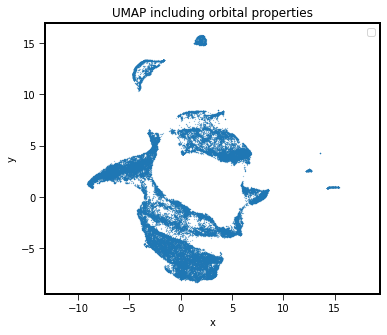

In [18]:
plt.figure().set_figwidth(20)
plt.figure().set_figheight(5)
plt.scatter(
    embedding_OP_spectra[:, 0],
    embedding_OP_spectra[:, 1], s = 0.03)

plt.gca().set_aspect('equal', 'datalim')
plt.xlabel('x')
plt.ylabel('y')
plt.title('UMAP including orbital properties')
plt.legend(prop={'size': 10})
plt.savefig('UMAP including orbital properties.pdf')
plt.show()


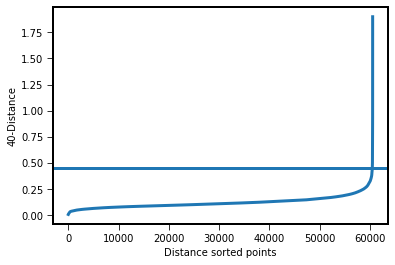

In [19]:
k = 40

# Compute k-nearest neighbors
# you need to add 1 to k as this function also return 
# distance to itself (first column is zero)
nbrs = NearestNeighbors(n_neighbors=k+1).fit(embedding_OP_spectra)
#
## get distances
dist, ind = nbrs.kneighbors(embedding_OP_spectra)
k_dist = np.sort(dist[:, -1])
plt.plot(k_dist)
plt.xlabel('Distance sorted points')
plt.ylabel(f'{k}-Distance')
plt.axhline(y = 0.45)
plt.show()

#clustering = DBSCAN(eps = 0.8, min_samples=k).fit(embedding_OP_spectra)
#clusters = clustering.labels_
#
#plt.figure().set_figwidth(20)
#plt.figure().set_figheight(5)
#plt.scatter(
#    embedding_OP_spectra[:, 0],
#    embedding_OP_spectra[:, 1], s = 0.03, c = hdb.labels_)
#plt.gca().set_aspect('equal', 'datalim')
#plt.title('UMAP projection of clustered data')
#plt.legend(prop={'size': 20})
#plt.show()
#
#unique, counts = np.unique(hdb.labels_, return_counts=True)
#print(unique, counts)

In [20]:
def dbscan_epsilon(data, num_clusters, min_epsilon, max_epsilon, number_of_interations):
    range_epsilon = np.arange(min_epsilon, max_epsilon, (max_epsilon-min_epsilon)/number_of_interations)
    num_of_cluster = np.array([])
    fraction_in_clusters = np.array([])

    for epsilon in range_epsilon:
        clustering = DBSCAN(eps = epsilon, min_samples=num_clusters).fit(data)
        clusters = clustering.labels_

        unique, counts = np.unique(clusters, return_counts=True)
        counts = np.delete(counts, np.argmax(counts))
        fraction_in_clusters = np.append(fraction_in_clusters, np.sum(counts[1:])/60518)
        num_of_cluster = np.append(num_of_cluster, len(unique))

    df = pd.DataFrame({'epsilon': range_epsilon, 'Number of clusters': num_of_cluster, 'Fraction in clusters': fraction_in_clusters, 'Participation score': num_of_cluster*fraction_in_clusters})
    df.set_index('epsilon', inplace=True)
    return df

In [21]:
dbscan_epsilon_score = dbscan_epsilon(embedding_OP_spectra, 40, 0.1, 0.3, 50)

In [29]:
dbscan_epsilon_score

,Number of clusters,Fraction in clusters,Participation score
epsilon,,,
0.100,135.0,0.605621,81.758898
0.104,128.0,0.645444,82.616874
0.108,118.0,0.676774,79.859315
0.112,117.0,0.710384,83.114891
0.116,110.0,0.735451,80.899567
0.120,102.0,0.764549,77.984038
0.124,84.0,0.788757,66.255593
0.128,84.0,0.815394,68.493076
0.132,77.0,0.727089,55.985888


In [26]:
dbscan_epsilon_score.index[dbscan_epsilon_score['Participation score'] == np.max(dbscan_epsilon_score['Participation score']) ]

Index([0.11200000000000002], dtype='float64', name='epsilon')

In [27]:
clustering = DBSCAN(eps = 0.132, min_samples=40).fit(embedding_OP_spectra)
clusters = clustering.labels_

In [17]:
clusters = np.loadtxt('clusters_op_spectra.csv', delimiter=',')

In [18]:
plt.figure().set_figwidth(20)
plt.figure().set_figheight(5)
plt.scatter(
    embedding_OP_spectra[:, 0],
    embedding_OP_spectra[:, 1], s = 0.03, c = clusters)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of clustered data')
plt.legend(prop={'size': 20})
plt.show()


NameError: name 'embedding_OP_spectra' is not defined

<Figure size 1440x288 with 0 Axes>

<Figure size 432x360 with 0 Axes>

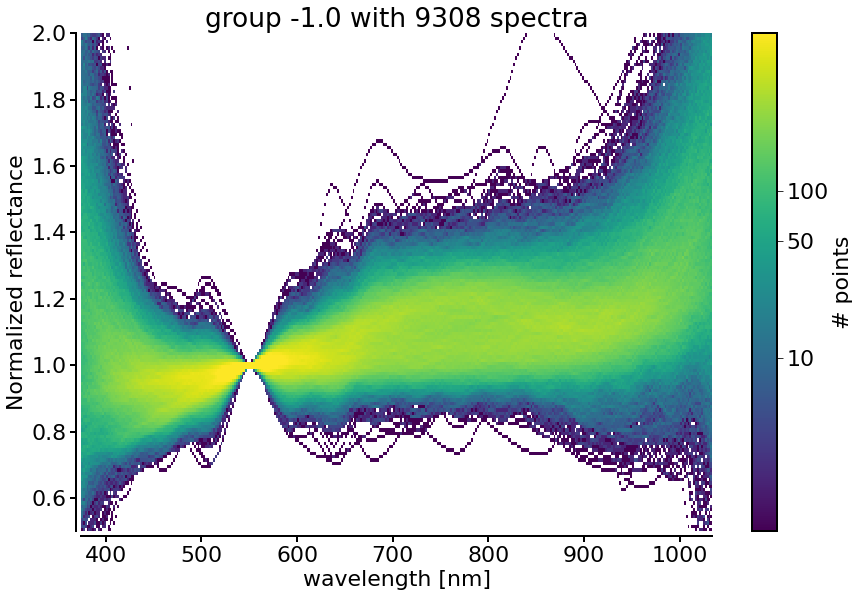

{nan, 'Hoffmeister', 'Padua', 'Nysa', 'Emma', 'Agnia', 'Phocaea', 'Ino', 'Gallia', 'Xizang', 'Jones', 'Juliana', 'Brasilia', 'Phaeo', 'Aeria', 'Koronis', 'Adeona', 'Barcelona', 'Hanna', 'Julia', 'Vesta', 'Iannini', 'Imhilde', 'Merxia', 'Tirela', '1993 FY12', 'Charis', 'Inarradas', 'Naema', 'Fringilla', 'Themis', 'Juno', 'Witt', 'Telramund', 'Brangane', 'Luthera', 'Lorre', 'Anfimov', 'Euphrosyne', 'Massalia', 'Tina', 'Maria', 'Veritas', 'Gefion', 'Dora', 'Hansa', '1998 YB3', 'Ulla', 'Nemesis', 'Hygiea', 'Leonidas', 'Postrema', 'Mitidika', 'Theobalda', 'Baptistina', '2000 BY6', 'Durisen', 'Yakovlev', 'Terpsichore', 'Ursula', 'Brucato', 'Karma', 'Watsonia', 'Chloris', 'Konig', 'Pallas', 'Itha', 'Rafita', '1999 CG1', 'Eunomia', 'Emilkowalski', 'Gersuind', 'Aegle', 'Aeolia', 'San Marcello', 'Svea', 'Eos', 'Klio', 'Misa', 'Chaldaea', 'Chimaera', 'Sylvia', 'Henan', 'Alauda', 'Lixiaohua', 'Erigone', 'Flora', 'Meliboea', 'Sulamitis'}


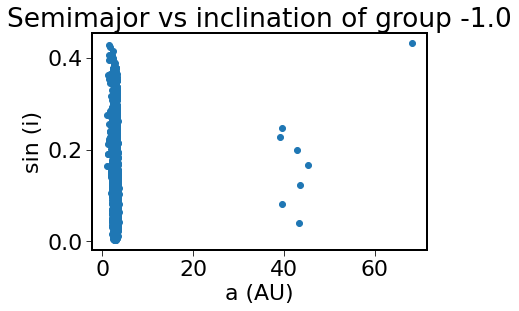

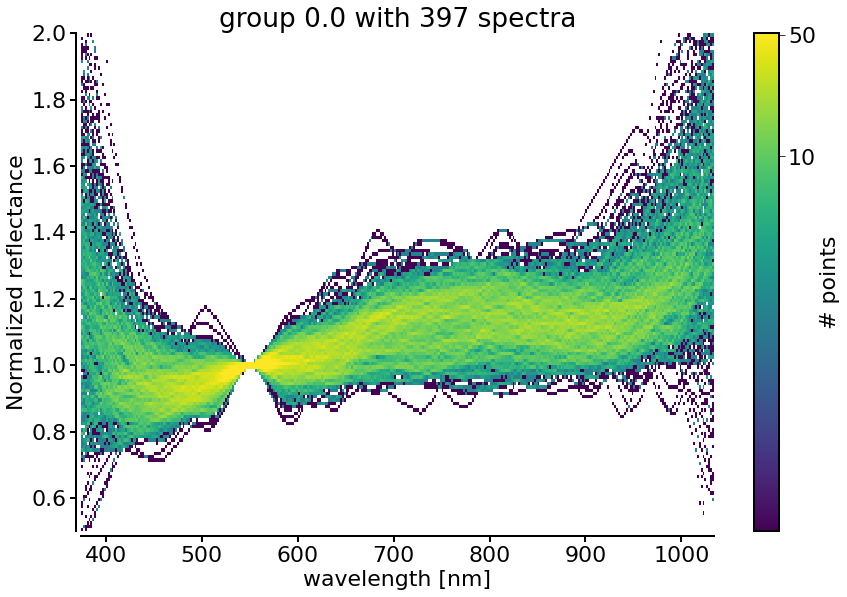

{nan, 'Aeria', 'Gefion', 'San Marcello', 'Karma', '1993 FY12', 'Maria'}


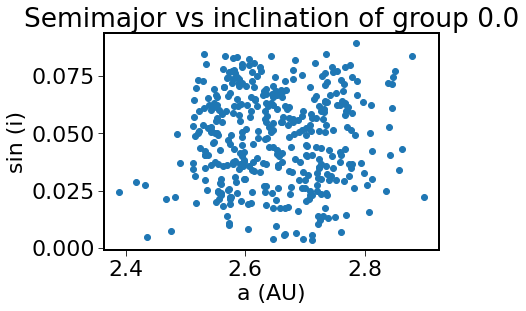

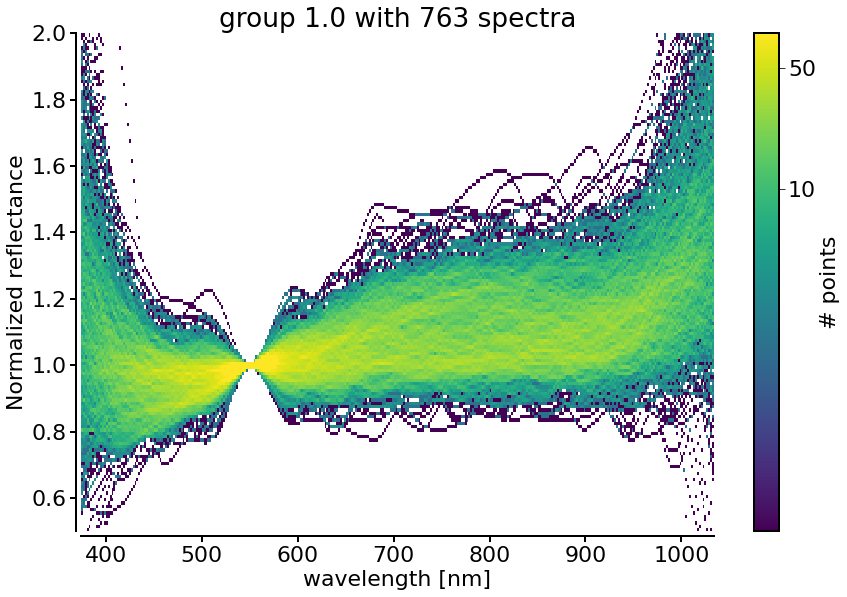

{nan, 'Mitidika', 'Juno', 'Chaldaea', 'Chimaera', 'Iannini', 'Postrema', 'Chloris'}


KeyboardInterrupt: 

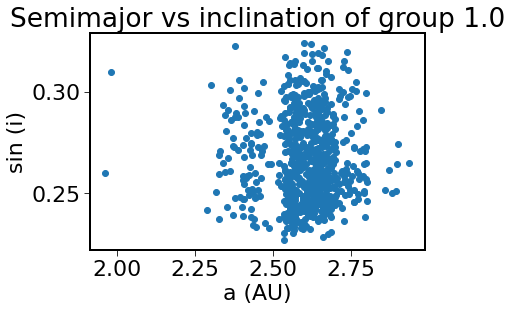

In [19]:
unique_labels = np.unique(clusters)
for n in unique_labels:
    i=1
    group = []
    non_group_indices = []
    index = np.array([])

    while i <len(clusters)+1:
            if clusters[i-1] == n:
                index_ssospectra = (i*16)-1
                mp_number = ssospectra.number_mp[index_ssospectra]
                group.append(mp_number)
                index = np.append(index, i-1)
                i+=1
            else:
                i+=1

    plt.rcParams.update({'font.size': 22})
    fig = plt.figure(figsize=(2 * 12, 2 * 8), tight_layout=True)
    gs = GridSpec(2, 2, figure=fig)
    axspectra = []
    axspectra.append(fig.add_subplot(gs[0, 0]))
    for axx in axspectra:
        apply_tufte(axx)

    plt.rcParams.update({'font.size': 22})
    plot_spectra_collection(ssospectra, axspectra[0], fig, group, cbarticks=[10, 50, 100])
    plt.title(f'group {n} with {len(group)} spectra')
    plt.show()

    plt.figure()
    plt.scatter(MP3C.a.iloc[index], MP3C.e.iloc[index])
    plt.title(f'Semimajor vs inclination of group {n}')
    plt.xlabel('a (AU)')
    plt.ylabel('sin (i)')
    plt.show
    print(set(MP3C.parent_name.iloc[index]))

In [18]:
clusters = np.loadtxt('clusters_op_spectra.csv', delimiter=',')

In [19]:
a = MP3C.parent_name.values 
a
cleaned_arr = a[~(a != a)]
len(cleaned_arr)

23704

In [20]:
a = (MP3C.a[MP3C.name == MP3C.parent_name] > 2.8) & (MP3C.a[MP3C.name == MP3C.parent_name] < 3.4) &  (MP3C.sin_i[MP3C.name == MP3C.parent_name] > 0) &  (MP3C.sin_i[MP3C.name == MP3C.parent_name] <0.15)  &  (MP3C.e[MP3C.name == MP3C.parent_name] > 0.2) &  (MP3C.e[MP3C.name == MP3C.parent_name] <0.3)
MP3C[MP3C.name == MP3C.parent_name][a]

,# number,name,parent,parent_name,a,e,sin_i,a_p,a_p_err,h,h_err,mass,mass_err,inverse_diameter,inverse_diameter_err
80,81.0,Terpsichore,81.0,Terpsichore,2.85212,0.21193,0.13580,2.8541,NaN,8.72,NaN,1.020000e+18,4.340000e+17,0.00831,0.000038
1667,1668.0,Hanna,1668.0,Hanna,2.80783,0.21617,0.08263,2.8061,NaN,12.24,NaN,NaN,NaN,0.04007,0.000137
10810,10811.0,Lau,10811.0,Lau,2.93301,0.21850,0.12535,2.9292,NaN,12.86,NaN,NaN,NaN,0.13022,0.001064


In [21]:
np.sort(MP3C.mass[clusters == 45])
MP3C[clusters == 45]

,# number,name,parent,parent_name,a,e,sin_i,a_p,a_p_err,h,h_err,mass,mass_err,inverse_diameter,inverse_diameter_err
716,717.0,Wisibada,NaN,NaN,3.13830,0.26477,0.02872,3.1471,NaN,10.96,NaN,NaN,NaN,0.03447,0.000168
793,794.0,Irenaea,NaN,NaN,3.13118,0.29525,0.09443,3.1396,NaN,11.45,NaN,NaN,NaN,0.02644,0.000877
881,882.0,Swetlana,NaN,NaN,3.12505,0.26833,0.10676,3.1345,NaN,10.77,NaN,NaN,NaN,0.02361,0.000111
958,959.0,Arne,NaN,NaN,3.17416,0.22249,0.07844,3.1855,NaN,10.81,NaN,NaN,NaN,0.02030,0.000096
1536,1537.0,Transylvania,NaN,NaN,3.06060,0.29372,0.06724,3.0498,NaN,12.36,NaN,NaN,NaN,0.05108,0.000591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195740,195741.0,2002PN98,NaN,NaN,3.09525,0.28642,0.08975,3.0994,NaN,15.52,NaN,NaN,NaN,NaN,NaN
203270,203271.0,2001RU5,NaN,NaN,2.98469,0.25987,0.09917,2.9894,NaN,15.54,NaN,NaN,NaN,0.18825,0.009108
206797,206798.0,2004DV39,NaN,NaN,2.96388,0.25086,0.07930,2.9727,NaN,15.79,NaN,NaN,NaN,NaN,NaN
211887,211888.0,2004JE15,NaN,NaN,3.04032,0.21754,0.10765,3.0467,NaN,15.43,NaN,NaN,NaN,0.25170,0.008553


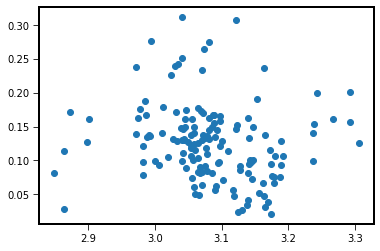

In [22]:
k = 86
plt.scatter(MP3C.a.iloc[clusters == 45], MP3C.inverse_diameter.iloc[clusters == 45])
#plt.scatter(MP3C.a.iloc[clusters == 45].iloc[k], MP3C.e.iloc[clusters == 45].iloc[k])
plt.show()

In [23]:
a1 = np.min(MP3C.a.iloc[clusters == 45])
e1 = np.min(MP3C.e.iloc[clusters == 45])
i1 = np.min(MP3C.sin_i.iloc[clusters == 45])
a2 = np.max(MP3C.a.iloc[clusters == 45])
e2 = np.max(MP3C.e.iloc[clusters == 45])
i2 = np.max(MP3C.sin_i.iloc[clusters == 45])

condition1 = (MP3C_catalogue.a > a1) & (MP3C_catalogue.a < a2) &  (MP3C_catalogue.e > e1) &  (MP3C_catalogue.e < e2) &  (MP3C_catalogue.sin_i > i1) &  (MP3C_catalogue.sin_i < i2) 
condition2 = (MP3C.a > a1) & (MP3C.a < a2) &  (MP3C.e > e1) &  (MP3C.e < e2) &  (MP3C.sin_i > i1) &  (MP3C.sin_i < i2) 

In [ ]:
MP3C_catalogue[MP3C_catalogue.parent == 5614]

,# number,name,parent,parent_name,a,e,sin_i,a_p,a_p_err,h,h_err,mass,mass_err,inverse_diameter,inverse_diameter_err
5613,5614.0,Yakovlev,5614.0,Yakovlev,2.87250,0.32831,0.11626,2.8705,NaN,13.61,NaN,NaN,NaN,0.07664,0.000335
10380,10381.0,Malinsmith,5614.0,Yakovlev,2.87724,0.31297,0.13940,2.8794,NaN,14.01,NaN,NaN,NaN,0.09229,0.000785
12282,12283.0,1991EC,5614.0,Yakovlev,2.88611,0.24684,0.13011,2.8833,NaN,13.45,NaN,NaN,NaN,0.07207,0.000174
33219,33220.0,1998FS109,5614.0,Yakovlev,2.89436,0.25615,0.10909,2.8937,NaN,15.13,NaN,NaN,NaN,0.18484,0.048517
51556,51557.0,2001FL176,5614.0,Yakovlev,2.87459,0.30194,0.16387,2.8763,NaN,14.67,NaN,NaN,NaN,0.11960,0.005496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365382,365383.0,2009UX141,5614.0,Yakovlev,2.87536,0.31791,0.16560,2.8710,NaN,16.28,NaN,NaN,NaN,0.22316,0.013945
370480,370481.0,2003NQ1,5614.0,Yakovlev,2.89695,0.28253,0.12827,2.8918,NaN,16.45,NaN,NaN,NaN,NaN,NaN
370493,370494.0,2003SC26,5614.0,Yakovlev,2.89277,0.31738,0.14218,2.8943,NaN,16.55,NaN,NaN,NaN,0.28409,0.079093
379955,379956.0,2012PJ33,5614.0,Yakovlev,2.85355,0.26195,0.12118,2.8462,NaN,16.60,NaN,NaN,NaN,NaN,NaN


NameError: name 'condition' is not defined

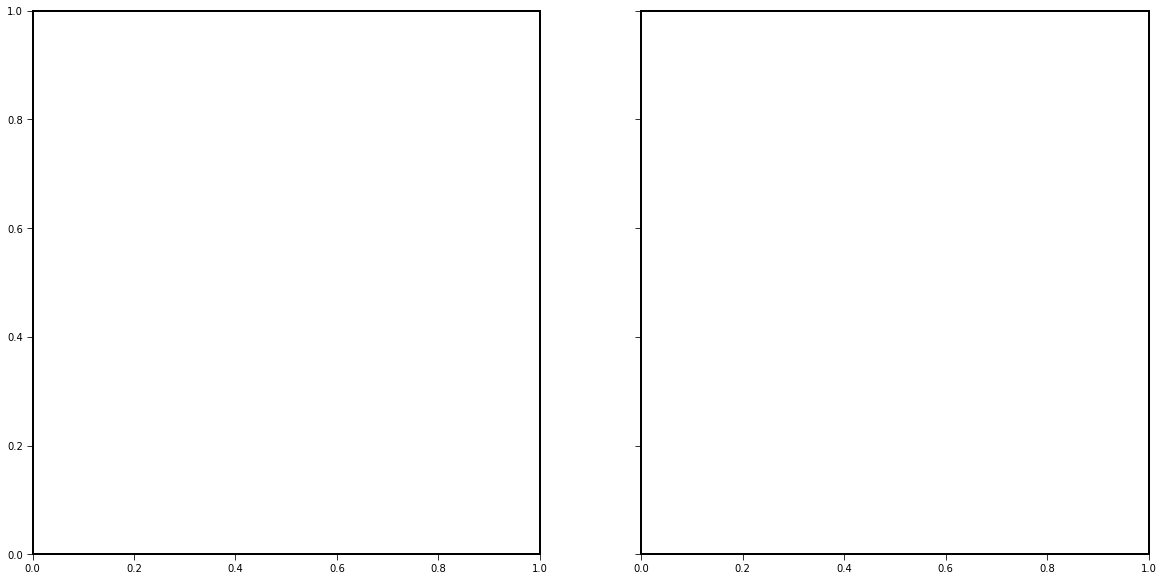

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10), sharex=True, sharey=True)
ax1.scatter(MP3C_catalogue.a[condition], MP3C_catalogue.e[condition], s = 3)
ax1.scatter(MP3C_catalogue.a[condition][MP3C_catalogue.parent == 5614], MP3C_catalogue.e[condition][MP3C_catalogue.parent == 5614], label = 'Yakovlev')
ax1.scatter(MP3C_catalogue.a[condition][MP3C_catalogue.parent == 10811], MP3C_catalogue.e[condition][MP3C_catalogue.parent == 10811], label = 'Lau')
ax1.scatter(MP3C_catalogue.a[condition][MP3C_catalogue.parent == 24], MP3C_catalogue.e[condition][MP3C_catalogue.parent == 24], label = 'Themis')
ax1.scatter(MP3C_catalogue.a[condition][MP3C_catalogue.parent == 81], MP3C_catalogue.e[condition][MP3C_catalogue.parent == 81], label = 'Terpsichore')
ax1.scatter(MP3C_catalogue.a[condition][MP3C_catalogue.parent == 106302.0], MP3C_catalogue.e[condition][MP3C_catalogue.parent == 106302.0], label = '2000 UJ87')

ax1.set_title('Asteroids in MP3C inside orbital parameters of cluster 45')
ax1.set_xlabel('Semi major axis (au)')
ax1.set_ylabel('Eccentricity')
ax1.legend()

ax2.scatter(MP3C.a[condition2], MP3C.e[condition2], s = 15)
ax2.scatter(MP3C.a[condition2][MP3C.parent_name == 'Yakovlev'], MP3C.e[condition2][MP3C.parent_name == 'Yakovlev'], label = 'Yakovlev')
ax2.scatter(MP3C.a[condition2][MP3C.parent_name == 'Lau'], MP3C.e[condition2][MP3C.parent_name == 'Lau'], label = 'Lau')
ax2.scatter(MP3C.a[condition2][MP3C.parent_name == 'Themis'], MP3C.e[condition2][MP3C.parent_name == 'Themis'], label = 'Themis')
ax2.set_title('Gaia asteroids inside orbital parameters of cluster 45')
ax2.set_xlabel('Semi major axis (au)')
ax2.legend()

plt.savefig('Asteroids_orbital_property_45.pdf')
plt.legend()

In [ ]:
plt.scatter(MP3C.a[condition], MP3C.e[condition])
plt.scatter(MP3C.a[condition][MP3C.parent_name == 'Yakovlev'], MP3C.e[condition][MP3C.parent_name == 'Yakovlev'], label = 'Yakovlev')
plt.scatter(MP3C.a[condition][MP3C.parent_name == 'Lau'], MP3C.e[condition][MP3C.parent_name == 'Lau'], label = 'Lau')
plt.scatter(MP3C.a[condition][MP3C.parent_name == 'Themis'], MP3C.e[condition][MP3C.parent_name == 'Themis'], label = 'Themis')
plt.legend()

#{'Lau', 'Themis', 'Yakovlev', nan}

NameError: name 'condition' is not defined

In [26]:
#array([2.40000e+01, 8.10000e+01, 5.61400e+03, 1.08110e+04, 1.06302e+05, nan])

num_45_catalogie_in_family = len(MP3C_catalogue[condition][MP3C_catalogue.parent == 5614]) + len(MP3C_catalogue[condition][MP3C_catalogue.parent == 24]) + len(MP3C_catalogue[condition][MP3C_catalogue.parent == 81]) + len(MP3C_catalogue[condition][MP3C_catalogue.parent == 10811]) + len(MP3C_catalogue[condition][MP3C_catalogue.parent == 106302])
fraction_in_family = num_45_catalogie_in_family/len(MP3C_catalogue[condition])

num_45_catalogie_in_family2 = len(MP3C[condition2][MP3C.parent == 5614]) + len(MP3C[condition2][MP3C.parent == 24]) + len(MP3C[condition2][MP3C.parent == 81]) + len(MP3C[condition2][MP3C.parent == 10811]) + len(MP3C[condition2][MP3C.parent == 106302])
fraction_in_family2 = num_45_catalogie_in_family2/len(MP3C[condition2])


print(fraction_in_family*100, fraction_in_family2*100)

NameError: name 'condition' is not defined

In [204]:
none_asteroids = pd.read_csv('none_asteroids.csv')
cond_C_no_fam = np.isin(sso_number_mp, none_asteroids['# number'])

cond_C_no_fam_1 = (cond_C_no_fam) & (MP3C.a > 2.2) & (MP3C.a < 2.5)
cond_C_no_fam_2 = (cond_C_no_fam) & (MP3C.a > 2.53) & (MP3C.a < 2.85)
cond_C_no_fam_3 = (cond_C_no_fam) & (MP3C.a > 2.97) & (MP3C.a < 3.25)

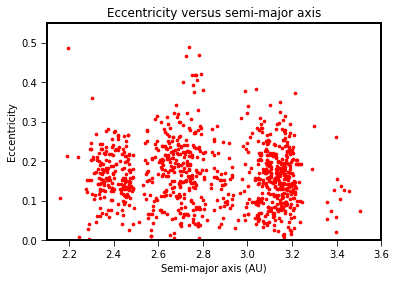

In [ ]:
plt.scatter(MP3C.a[cond_C_no_fam], MP3C.e[cond_C_no_fam], s = 7, c = 'r')
plt.xlim(2.1,3.6)
plt.ylim(0,0.55)
plt.title('Eccentricity versus semi-major axis')
plt.xlabel('Semi-major axis (AU)')
plt.ylabel('Eccentricity')


In [206]:
def distance(a1, e1, sin_i_1, a2, e2, sin_i_2):
    G = 6.67*10**-11
    M = 2*10**30
    mean_a = (a1+a2)/2
    delta_a = a1-a2
    delta_e = e1-e2
    delta_sin_i = sin_i_1 - sin_i_2
    a_new = a1*1.5*10**11
    distance = np.sqrt(G*M/(a_new))*np.sqrt(1.25*((delta_a/mean_a)**2)+2*(delta_e**2+delta_sin_i**2))
    return distance

In [207]:
def distances(cluster_number, number_of_asteroids):
    
    my_list = list(np.arange(0,number_of_asteroids))
    combinations = list(itertools.combinations(my_list,2))
    distances = np.array([])

    for i in combinations:
        a1 = MP3C.a.iloc[clusters == cluster_number].iloc[i[0]]
        e1 = MP3C.e.iloc[clusters == cluster_number].iloc[i[0]]
        i1 = MP3C.sin_i.iloc[clusters == cluster_number].iloc[i[0]]
        a2 = MP3C.a.iloc[clusters == cluster_number].iloc[i[1]]
        e2 = MP3C.e.iloc[clusters == cluster_number].iloc[i[1]]
        i2 = MP3C.sin_i.iloc[clusters == cluster_number].iloc[i[1]]
        distance1 = distance(a1, e1, i1, a2, e2, i2)
        distances = np.append(distances, distance1)
    return distances, combinations


def distance_pair(cluster_number, combination):
    a1 = MP3C.a.iloc[clusters == cluster_number].iloc[combination[0]]
    e1 = MP3C.e.iloc[clusters == cluster_number].iloc[combination[0]]
    i1 = MP3C.sin_i.iloc[clusters == cluster_number].iloc[combination[0]]
    a2 = MP3C.a.iloc[clusters == cluster_number].iloc[combination[1]]
    e2 = MP3C.e.iloc[clusters == cluster_number].iloc[combination[1]]
    i2 = MP3C.sin_i.iloc[clusters == cluster_number].iloc[combination[1]]
    distance1 = distance(a1, e1, i1, a2, e2, i2)
    return distance1

def distance_family(condition, number_of_asteroids):
    
    my_list = list(np.arange(0,number_of_asteroids))
    combinations = list(itertools.combinations(my_list,2))
    distances = np.array([])
    
    for i in combinations:
        a1 = MP3C[condition].a.iloc[i[0]]
        e1 = MP3C[condition].e.iloc[i[0]]
        i1 = MP3C[condition].sin_i.iloc[i[0]]
        a2 = MP3C[condition].a.iloc[i[1]]
        e2 = MP3C[condition].e.iloc[i[1]]
        i2 = MP3C[condition].sin_i.iloc[i[1]]
        distance1 = distance(a1, e1, i1, a2, e2, i2)
        distances = np.append(distances, distance1)
    return distances, combinations

In [208]:
print(len(MP3C[condition2]), len(MP3C[clusters == 29]))

288 55


In [378]:
cluster = 29

a1 = np.min(MP3C.a.iloc[clusters == cluster])
e1 = np.min(MP3C.e.iloc[clusters == cluster])
i1 = np.min(MP3C.sin_i.iloc[clusters == cluster])
a2 = np.max(MP3C.a.iloc[clusters == cluster])
e2 = np.max(MP3C.e.iloc[clusters == cluster])
i2 = np.max(MP3C.sin_i.iloc[clusters == cluster])

condition1 = (MP3C_catalogue.a > a1) & (MP3C_catalogue.a < a2) &  (MP3C_catalogue.e > e1) &  (MP3C_catalogue.e < e2) &  (MP3C_catalogue.sin_i > i1) &  (MP3C_catalogue.sin_i < i2) 
condition2 = (MP3C.a > a1) & (MP3C.a < a2) &  (MP3C.e > e1) &  (MP3C.e < e2) &  (MP3C.sin_i > i1) &  (MP3C.sin_i < i2) 
len(MP3C_catalogue[condition1]), len(MP3C[clusters == cluster])

c_1, v_1  = np.unique(list(MP3C.parent_name[condition2]), return_counts=True)
c_1,v_1, np.sum(v_1), len(MP3C[cond_C_no_fam_3])


(array(['Vesta', 'nan'], dtype='<U32'),
 array([180, 229], dtype=int64),
 409,
 379)

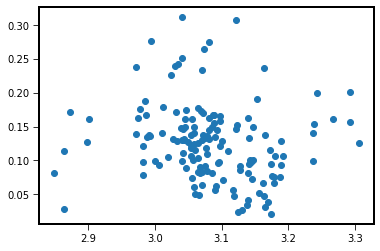

In [31]:
plt.scatter(MP3C.a[clusters == 45], MP3C.inverse_diameter[clusters == 45])

In [ ]:
distance_cluster, combinations = distances(cluster, len(MP3C[clusters == cluster])) #for cluster number
#distance_cluster, combinations = distance_family(condition2, len(MP3C[condition2]))  #for condition
#a = np.argmin(distance_cluster)
#len(distance_cluster[distance_cluster < 50])
#
#ar = np.array([])
#for i in np.arange(0,len(distance_cluster)):
#    if distance_cluster[i] <50: 
#        a = combinations[i][0]
#        b = combinations[i][1]
#
#        ar = np.append(ar, a)
#        ar = np.append(ar, b)
#    else:
#        continue

In [379]:
k = 10
k3 = k**3

data =  MP3C.iloc[clusters == cluster]  #for cluster number
#data =  MP3C[cond_C_no_fam_3]  #for condition

min_a = np.min(data.a)  
max_a = np.max(data.a)  

min_e = np.min(data.e)  
max_e = np.max(data.e)  

min_i = np.min(data.sin_i)  
max_i = np.max(data.sin_i) 

arange_a = np.linspace(min_a, max_a, k+1)
arange_e = np.linspace(min_e, max_e, k+1)
arange_i = np.linspace(min_i, max_i, k+1) 

arange_a2 = np.array([[arange_a[i], arange_a[i+1]] for i in np.arange(0,len(arange_a)-1)])
arange_e2 = np.array([[arange_e[i], arange_e[i+1]] for i in np.arange(0,len(arange_e)-1)])
arange_i2 = np.array([[arange_i[i], arange_i[i+1]] for i in np.arange(0,len(arange_i)-1)])

In [380]:
#condition = (MP3C_catalogue.a > min_a) & (MP3C_catalogue.a < max_a) &  (MP3C_catalogue.e > min_e) &  (MP3C_catalogue.e < max_e) &  (MP3C_catalogue.sin_i > min_i) &  (MP3C_catalogue.sin_i < max_i) 
#new = MP3C_catalogue[condition]
#new = new[new['parent'].isnull()]

In [381]:
condition_array = np.array([])
for i in arange_a2:
    a1 = i[0]
    a2 = i[1]
    for j in arange_e2:
        e1 = j[0]
        e2 = j[1]
        for k in arange_i2:
            i1 = k[0]
            i2 = k[1]

            condition_array = np.append(condition_array, [a1, a2, e1, e2, i1, i2])



In [382]:
condition_array_split = np.split(condition_array, k3)

In [383]:
lengths = np.array([])

for i in condition_array_split:
    condition3 = (data.a > i[0]) & (data.a < i[1]) &  (data.e > i[2]) &  (data.e < i[3]) &  (data.sin_i > i[4]) &  (data.sin_i < i[5]) 
    length = len(data[condition3])
    lengths = np.append(lengths, length)

In [384]:
max_index = condition_array_split[np.argmax(lengths)]
condition_density = (data.a > max_index[0]) & (data.a < max_index[1]) &  (data.e > max_index[2]) &  (data.e < max_index[3]) &  (data.sin_i > max_index[4]) &  (data.sin_i < max_index[5]) 
data_density = data[condition_density]
index_max_density  = np.argmax(condition_density*1)
combinations_new = np.array([combinations])[0]

In [385]:
def combinations_function(index_asteroid):
    distance_combinations = [distance_cluster[n] for n in range(0,len(combinations_new)) if combinations_new[:,0][n] == index_asteroid or  combinations_new[:,1][n] == index_asteroid]
    numbers_combinations = [combinations_new[n] for n in range(0,len(combinations_new)) if combinations_new[:,0][n] == index_asteroid or  combinations_new[:,1][n] == index_asteroid]
    return distance_combinations, numbers_combinations

In [386]:
def value(index, cutoff_velocity):
    dist, nums = combinations_function(index)
    array = [[i,j] for i,j in list(zip(dist,nums)) if i <cutoff_velocity]
    return array

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


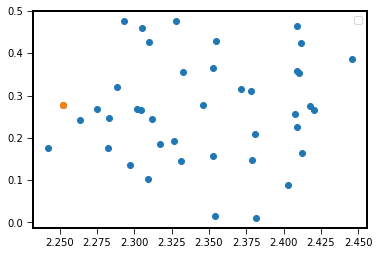

In [389]:
value(index_max_density, 100)
plt.scatter(MP3C.a[clusters == cluster], MP3C.inverse_diameter[clusters == cluster])
plt.scatter(MP3C.a[clusters == cluster].iloc[index_max_density], MP3C.inverse_diameter[clusters == cluster].iloc[index_max_density])
plt.legend()

In [390]:
def families(members, cutoff_velocity):

    family_memebers = members

    for n in family_memebers:
        a = value(n, cutoff_velocity)


        for i in a:
            first = i[1][0]
            second = i[1][1]
            family_memebers = np.append(family_memebers, [first, second])
    return np.unique(family_memebers)

    


In [391]:
families(np.array([index_max_density]), 20)

array([16], dtype=int64)

In [392]:
#cutoff_velocity = np.arange(10, 120, 5)
#num_asteroids_family = np.array([])
#for i in cutoff_velocity:
#    print(i)
#    len_old = 0
#    len_new = 1
#    array_old = families(np.array([index_max_density]), i)
#    #array2 = families(array_old)
#    #print(array_old, array2)
#    while len_old != len_new:
#        array_new = families(array_old, i)
#        len_old = len_new
#        len_new = len(array_new)
#        array_old = array_new
#    num_asteroids_family = np.append(num_asteroids_family, len_new)
#

In [393]:
#plt.plot(cutoff_velocity, num_asteroids_family)
#plt.title('Asteroid family in group 29')
#plt.xlabel('Cutoff velocity (m/s)')
#plt.ylabel('Number of asteroids')

In [394]:
#num_asteroids_family[49]
#cutoff_velocity[50]

In [395]:
cutoff_velocity = np.arange(10,120, 5)
num_asteroids_family = np.array([])
asteroids_in_family = []
for i in cutoff_velocity:
    print(i)
    len_old = 0
    len_new = 1
    array_old = families(np.array([index_max_density]), i)
    stakeholder_place = np.array([])
    #array2 = families(array_old)
    #print(array_old, array2)
    while len_old != len_new:
        new_values = families(list(set(array_old)-set(stakeholder_place)), i)
        array_new = np.unique(np.concatenate((array_old, new_values)))
        len_old = len_new
        len_new = len(array_new)
        stakeholder_place = array_old
        array_old = array_new
    num_asteroids_family = np.append(num_asteroids_family, len_new)
    asteroids_in_family.append([array_new])

10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115


In [396]:
#np.savetxt("asteroids_in_family_63.csv", asteroids_in_family[np.argmax(cutoff_velocity==80*1)])

In [397]:
asteroids_in_family

[[array([16], dtype=int64)],
 [array([16], dtype=int64)],
 [array([16], dtype=int64)],
 [array([16], dtype=int64)],
 [array([16], dtype=int64)],
 [array([16], dtype=int64)],
 [array([16], dtype=int64)],
 [array([16], dtype=int64)],
 [array([16], dtype=int64)],
 [array([16], dtype=int64)],
 [array([16], dtype=int64)],
 [array([16], dtype=int64)],
 [array([16], dtype=int64)],
 [array([16], dtype=int64)],
 [array([16], dtype=int64)],
 [array([16], dtype=int64)],
 [array([16], dtype=int64)],
 [array([16], dtype=int64)],
 [array([16], dtype=int64)],
 [array([16], dtype=int64)],
 [array([16], dtype=int64)],
 [array([16], dtype=int64)]]

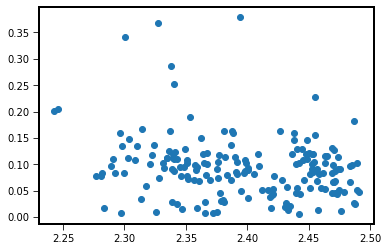

In [370]:
plt.scatter(MP3C.a[cond_C_no_fam_1], MP3C.inverse_diameter[cond_C_no_fam_1])

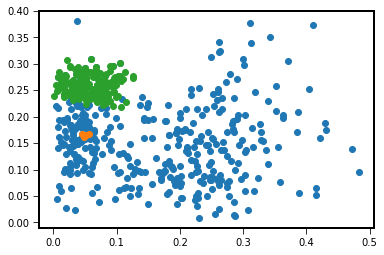

In [373]:
plt.scatter(MP3C.sin_i[cond_C_no_fam_3], MP3C.e[cond_C_no_fam_3])
plt.scatter(MP3C.sin_i[cond_C_no_fam_3].iloc[[6, 171, 207, 246]], MP3C.e[cond_C_no_fam_3].iloc[[6, 171, 207, 246]])
plt.scatter(MP3C.sin_i[clusters == 45], MP3C.e[clusters == 45])

In [136]:
for i in cutoff_velocity:
    c, v = np.unique(list(MP3C[condition2].parent_name.iloc[asteroids_in_family[np.argmax((cutoff_velocity==i)*1)][0]]), return_counts=True)
#num_asteroids_family[cutoff_velocity==90]
    print(c,v, i)

[nan] [1] 10
[nan] [1] 15
[nan] [1] 20
[nan] [1] 25
[nan] [1] 30
[nan] [1] 35
[nan] [1] 40
[nan] [1] 45
[nan] [1] 50
[nan] [1] 55
[nan] [1] 60
[nan] [1] 65
[nan] [1] 70
[nan] [1] 75
[nan] [1] 80
[nan] [1] 85
[nan] [1] 90
[nan] [1] 95
[nan] [1] 100
[nan] [1] 105
[nan] [1] 110
[nan] [1] 115


In [620]:
MP3C.inverse_diameter[condition2].iloc[asteroids_in_family[np.argmax((cutoff_velocity==115)*1)][0]].iloc[-2]

nan

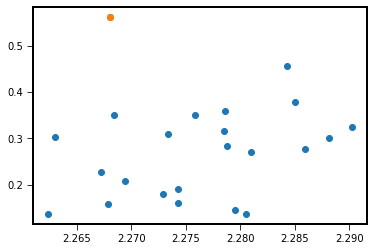

In [624]:
a = MP3C.a[condition2].iloc[asteroids_in_family[np.argmax((cutoff_velocity==90)*1)][0]]
d = MP3C.inverse_diameter[condition2].iloc[asteroids_in_family[np.argmax((cutoff_velocity==90)*1)][0]]
plt.scatter(a,d)
plt.scatter(a.iloc[-2],d.iloc[-2])

Text(0, 0.5, 'number of asteroids in family')

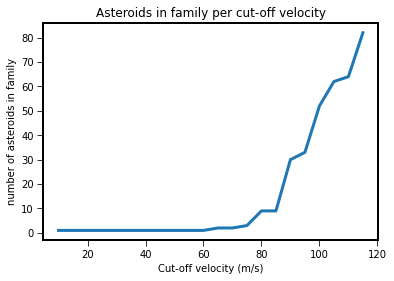

In [607]:
plt.plot(cutoff_velocity, num_asteroids_family)
plt.title('Asteroids in family per cut-off velocity')
plt.xlabel('Cut-off velocity (m/s)')
plt.ylabel('number of asteroids in family')

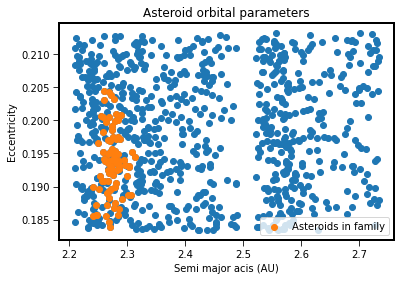

In [609]:
plt.scatter(MP3C.a[condition2], MP3C.e[condition2])
plt.scatter(MP3C.a[condition2].iloc[asteroids_in_family[np.argmax((cutoff_velocity==115)*1)][0]], MP3C.e[condition2].iloc[asteroids_in_family[np.argmax((cutoff_velocity==115)*1)][0]], label = 'Asteroids in family')
plt.title('Asteroid orbital parameters')
plt.xlabel('Semi major acis (AU)')
plt.ylabel('Eccentricity')
plt.legend()

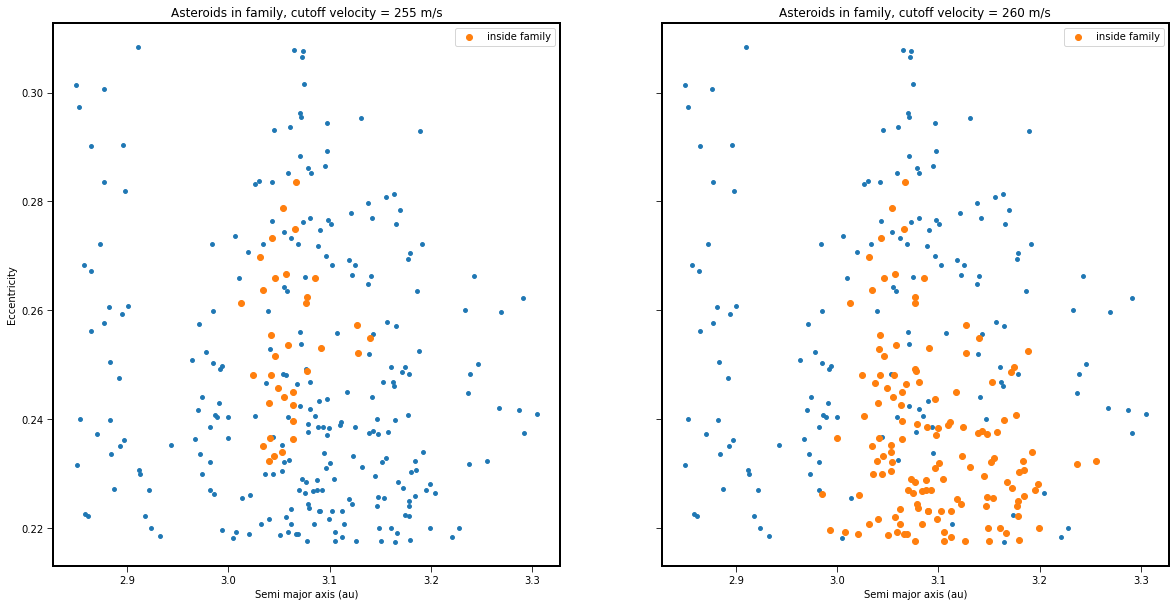

In [236]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10), sharex=True, sharey=True)
ax1.scatter(MP3C.a[condition2], MP3C.e[condition2], s = 15)
ax1.scatter(MP3C.a[condition2].iloc[fam_255], MP3C.e[condition2].iloc[fam_255], label = 'inside family')

ax1.set_title('Asteroids in family, cutoff velocity = 255 m/s')
ax1.set_xlabel('Semi major axis (au)')
ax1.set_ylabel('Eccentricity')
ax1.legend()

ax2.scatter(MP3C.a[condition2], MP3C.e[condition2], s = 15)
ax2.scatter(MP3C.a[condition2].iloc[fam_260], MP3C.e[condition2].iloc[fam_260], label = 'inside family')
ax2.set_title('Asteroids in family, cutoff velocity = 260 m/s')
ax2.set_xlabel('Semi major axis (au)')
ax2.legend()

plt.savefig('Asteroids_orbital_property_45.pdf')
plt.legend()

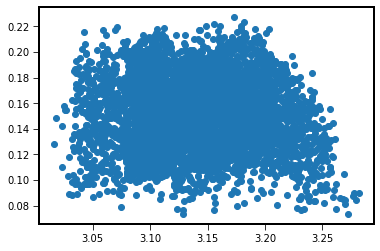

In [226]:
plt.scatter(MP3C_catalogue.a[MP3C_catalogue.parent_name == 'Themis'], MP3C_catalogue.e[MP3C_catalogue.parent_name == 'Themis'])

Text(0, 0.5, 'Number of asteroids')

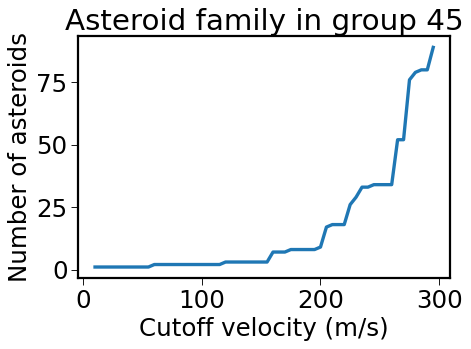

In [129]:
plt.plot(cutoff_velocity, num_asteroids_family)
plt.title('Asteroid family in group 45')
plt.xlabel('Cutoff velocity (m/s)')
plt.ylabel('Number of asteroids')

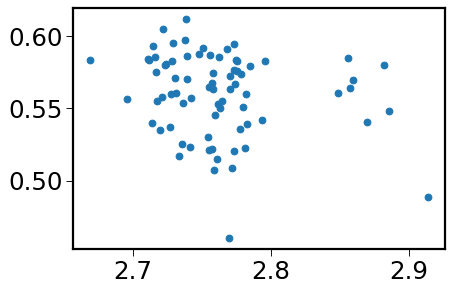

In [101]:
plt.scatter(MP3C.a[MP3C.parent == 2], MP3C.sin_i[MP3C.parent == 2])

In [ ]:
a = MP3C[clusters == 45].iloc[array_new].iloc[:,0]
np.savetxt("cluster_45_family.csv", a, delimiter=",")

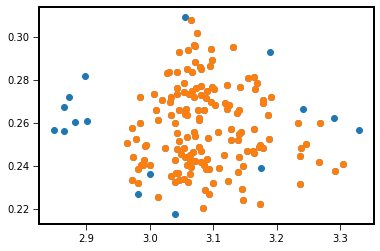

In [ ]:
plt.scatter(MP3C.a.iloc[clusters == 45], MP3C.e.iloc[clusters == 45])
plt.scatter(MP3C.a.iloc[clusters == 45].iloc[array_old], MP3C.e.iloc[clusters == 45].iloc[array_old])
plt.show()

In [ ]:
dis_array = np.array([])
for i in range(0, 166):
    dist, ad = combinations_function(i)
    dis_array = np.append(dis_array, np.min(dist))


In [ ]:
#for n in np.unique(clusters)[0:30]:   
        i=0
        group = []
        non_group_indices = []
        while i < len(clusters):
            if (clusters)[i] == n:
                group.append(i)
                i+=1
            else:
                non_group_indices.append(i)
                i+=1

        plt.scatter(MP3C.a.iloc[group], MP3C.inverse_diameter.iloc[group])
        #plt.scatter(MP3C.a[MP3C.name == 'Sylvia'], MP3C.sin_i[MP3C.name == 'Sylvia'])
        plt.title(f'Group {n} with {len(group)} objects')
        plt.show()
        print(MP3C.parent_name.iloc[group])

IndentationError: unexpected indent (<ipython-input-154-22ede12380e8>, line 2)